In [1]:
from bssp.common.reading import read_dataset_cached
from bssp.ontonotes.dataset_reader import OntonotesReader

model_name = 'bert-base-cased'
train_dataset = read_dataset_cached(OntonotesReader, 'data/conll-formatted-ontonotes-5.0/data/train', 'ontonotes', 'train', model_name, with_embeddings=True)
dev_dataset = read_dataset_cached(OntonotesReader, 'data/conll-formatted-ontonotes-5.0/data/dev', 'ontonotes', 'dev', model_name, with_embeddings=False)
test_dataset = read_dataset_cached(OntonotesReader, 'data/conll-formatted-ontonotes-5.0/data/test', 'ontonotes', 'test', model_name, with_embeddings=False)
all_instances = train_dataset + dev_dataset + test_dataset

/home/luke/.anaconda3/envs/sembre/lib/python3.8/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")


Reading split train from cache at cache/dataset/ontonotes_train__bert-base-cased.pkl
Reading split dev from cache at cache/dataset/ontonotes_dev__bert-base-cased.pkl
Reading split test from cache at cache/dataset/ontonotes_test__bert-base-cased.pkl


In [3]:
from collections import defaultdict
instance_index = defaultdict(list)
for instance in all_instances:
    lemma, pos, _ = instance['label'].label.split('_')
    instance_index[lemma + '_' + pos].append(instance)
print(len(instance_index))

3885


In [9]:
import os
from glob import glob
from lxml import etree
import matplotlib.pyplot as plt
lemma_files = glob('data/ontonotes-release-5.0/data/files/data/english/metadata/sense-inventories/*.xml')

agreements = []
lemma_counts = []
notas = []
single_sense = 0
multi_sense_no_agreement = 0
conflicting_counts = 0

total = 0
for lemma_filepath in lemma_files:
    # skip if not represented in our data
    key = lemma_filepath.split('/')[-1].replace('.xml','').replace('-','_')
    if key not in instance_index:
        continue
    total += 1
        
    with open(lemma_filepath, 'r') as f:
        t = etree.parse(lemma_filepath)
    root = t.getroot()
    
    sense_counter = 0
    for sense in root.iterfind('sense'):
        sense_counter += 1
        attribs = sense.attrib
        
        if attribs['name'] in ['Placeholder Sense: Do Not Choose', 'Placeholder: Do Not Choose', 'Do Not Choose', 'Do Not Choose: Placeholder Sense']:
            #print(f"Skipping placeholder sense in {lemma_filepath.split('/')[-1]}")
            continue
            
        commentary = sense.find('commentary').text
        if 'NOTA' in commentary or 'none of the above' in attribs['name']:
            notas.append(key + '_' + str(float(attribs['n'])))
            
    if sense_counter == 1:
        single_sense += 1
    else:
        if root.find('ita') is None:
            multi_sense_no_agreement += 1
        else:
            attrs = root.find('ita').attrib
            agreement = float(attrs['ann_1_2_agreement'])
            lemma_count = int(attrs['count'])
            if lemma_count != len(instance_index[key]):
                conflicting_counts += 1
            agreements.append(agreement)
            lemma_counts.append(lemma_count)
    

print(f'{len(notas)} out of {total} lemmas have NOTA senses')
print(f'{single_sense} out of {total} have only one sense')
print(f'{multi_sense_no_agreement} out of {total} have multiple senses but no reported agreement')
print(f'{conflicting_counts} out of {total} have reported counts that differed from actual counts')
print([x for x in notas if not x.endswith('0')])
with open('data/ontonotes_nota_senses.txt', 'w') as f:
    f.write('\n'.join(notas) + '\n')

3395 out of 3871 lemmas have NOTA senses
496 out of 3871 have only one sense
1 out of 3871 have multiple senses but no reported agreement
2163 out of 3871 have reported counts that differed from actual counts
['pass_v_13.13', 'stand_v_7.16', 'drop_v_13.11', 'sign_v_99.5', 'pick_v_7.13', 'live_v_5.8', 'play_v_12.13', 'think_v_6.8', 'run_v_13.21', 'make_v_17.9', 'get_v_11.38', 'break_v_16.11', 'stay_v_5.9', 'put_v_7.32', 'lay_v_5.12', 'beat_v_11.9', 'clean_v_5.9', 'keep_v_8.12', 'push_v_6.6', 'place_v_9.3']


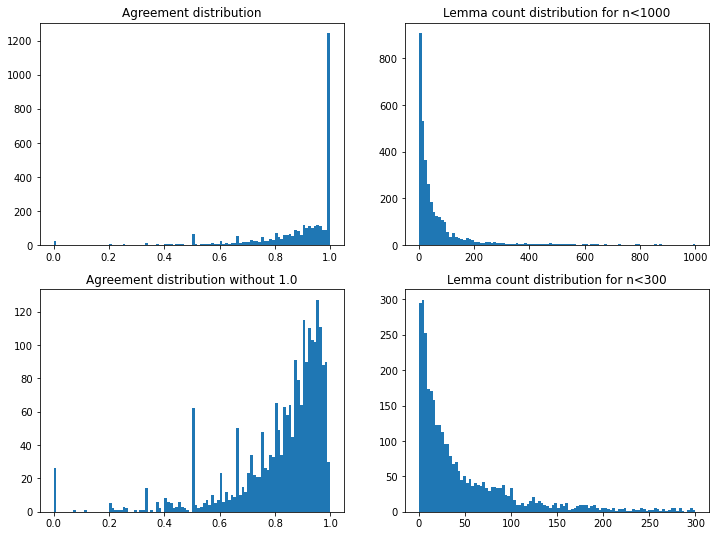

In [4]:
fig, ax = plt.subplots(2, 2)
fig.set_figwidth(12)
fig.set_figheight(9)

ax[0,0].hist(agreements, bins=100)
ax[0,0].set_title('Agreement distribution')

ax[1,0].hist([x for x in agreements if x != 1.0], bins=100)
ax[1,0].set_title('Agreement distribution without 1.0')

ax[0,1].hist(lemma_counts, bins=100, range=(0,1000))
ax[0,1].set_title('Lemma count distribution for n<1000')

ax[1,1].hist(lemma_counts, bins=100, range=(0,300))
ax[1,1].set_title('Lemma count distribution for n<300')
plt.show()